In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy

import mlrfit as mf
import mfmodel as mfm 

In [2]:
# np.random.seed(1001)
# random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 1000
signal_to_noise = 4

L = 5


ranks = np.array([5, 4, 3, 2, 1])
rank = ranks.sum()

nsamples = rank * 3
rank, nsamples

(15, 45)

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=1000.0
level=1, num_groups=3, mean_size=333.3
level=2, num_groups=7, mean_size=142.9
level=3, num_groups=16, mean_size=62.5
level=4, num_groups=1000, mean_size=1.0


In [5]:
hpart['rows']['lk'][:-1]

[array([   0, 1000]),
 array([   0,  250,  500, 1000]),
 array([   0,  125,  250,  375,  500,  750,  875, 1000]),
 array([   0,   62,  125,  187,  250,  312,  375,  437,  500,  562,  625,
         687,  750,  812,  875,  937, 1000])]

In [6]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=True)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=14.113427004586985, noise_var=3.532047655658369
SNR=3.99582009658821, signal_to_noise=4


In [7]:
true_D_noise.min(), true_D_noise.max()

(0.0016015476566186297, 7.055221250599871)

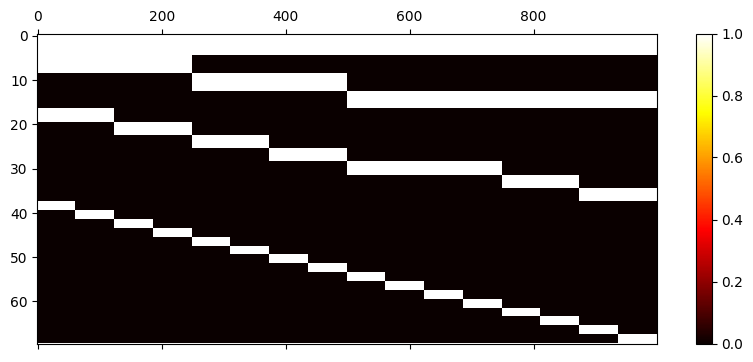

(1000, 70)


In [8]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T!=0, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [9]:
true_sparse_F.shape

(1000, 70)

In [10]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [11]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  6 15]


In [12]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0
pi = F_hpart['pi']
F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]
v = np.random.randn(n)

true_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F_Lm1, D=D)
true_mfm.inv_coefficients(printing=True)

/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [13]:
true_mlr.construct_sparse_format()
hat_x = mfm.iterative_refinement_linsolve(ranks, v[:, np.newaxis], F_Lm1, D, F_hpart, eps=1e-12, max_iter=50)
np.linalg.norm(hat_x - np.linalg.inv(true_mlr.matrix()) @ v[:, np.newaxis])

2.3019840384182744e-12

In [14]:
mfm_Sigma = mfm.MFModel(F=F_Lm1, D=D, hpart=F_hpart, ranks=ranks)
mfm_Sigma.inv_coefficients(det=True)

assert true_sparse_F.shape[1] == mfm_Sigma.num_factors()

## Data

In [15]:
# C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)
C = mfm.sample_data(nsamples, mfm_Sigma)

Z = (C - C.mean(axis=1, keepdims=True))[F_hpart["pi"], :]
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[mfm_Sigma.pi_inv, :][:, mfm_Sigma.pi_inv]

# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0] 

# Unscaled $Y$

## Frob initialization

In [16]:
fitted_mfm, loglikelihoods = mfm.fit(Y, ranks, F_hpart, printing=True, max_iter=2000, freq=500, init_type="frob")

/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/parshakova.tanya/Documents/projects/MLR_Matrices/multilevel_factor_model/mfmodel/mfmodel.py:267: RuntimeWarning: overflow encountered in scalar multiply
  determinant *= np.prod(eigvals)


t=0, obj=-1993.2068275880877, hist(D)=(array([574, 391,  35]), array([0.33305629, 2.98319223, 5.63332817, 8.2834641 ]))
t=500, obj=-1838.248053615585, hist(D)=(array([739, 258,   3]), array([4.98217499e-04, 3.25417084e+00, 6.50784346e+00, 9.76151607e+00]))
t=1000, obj=-1837.995043606455, hist(D)=(array([739, 258,   3]), array([2.61148201e-04, 3.25369167e+00, 6.50712219e+00, 9.76055271e+00]))
t=1500, obj=-1837.9282698999855, hist(D)=(array([739, 258,   3]), array([1.78456319e-04, 3.25348720e+00, 6.50679594e+00, 9.76010468e+00]))
t=1999, obj=-1837.9046301672995, hist(D)=(array([739, 258,   3]), array([1.35918286e-04, 3.25336418e+00, 6.50659245e+00, 9.75982071e+00]))


## Random initialization

In [17]:
fitted_mfm, loglikelihoods = mfm.fit(Y, ranks, F_hpart, printing=True, max_iter=2000, freq=500, init_type="random")

t=0, obj=-36100.426222733855, hist(D)=(array([324, 331, 345]), array([0.0030791 , 0.33569226, 0.66830542, 1.00091858]))
t=500, obj=-1844.5427981711493, hist(D)=(array([739, 258,   3]), array([5.55495148e-04, 3.25211196e+00, 6.50366843e+00, 9.75522490e+00]))
t=1000, obj=-1841.7464571150228, hist(D)=(array([739, 258,   3]), array([2.78037641e-04, 3.25213563e+00, 6.50399322e+00, 9.75585081e+00]))
t=1500, obj=-1840.5514732041383, hist(D)=(array([739, 258,   3]), array([1.87693606e-04, 3.25181487e+00, 6.50344205e+00, 9.75506923e+00]))
t=1999, obj=-1839.9089248213256, hist(D)=(array([738, 259,   3]), array([1.44449676e-04, 3.25172146e+00, 6.50329847e+00, 9.75487548e+00]))


## $Y$ initialization

In [18]:
fitted_mfm, loglikelihoods = mfm.fit(Y, ranks, F_hpart, printing=True, max_iter=2000, freq=500, init_type="Y")

t=0, obj=-2752.9501509216166, hist(D)=(array([634, 331,  35]), array([ 3.84403948, 18.31419163, 32.78434379, 47.25449594]))
t=500, obj=-1839.1907788102071, hist(D)=(array([738, 259,   3]), array([5.21395639e-04, 3.25160406e+00, 6.50268673e+00, 9.75376940e+00]))
t=1000, obj=-1838.3673299189993, hist(D)=(array([738, 259,   3]), array([2.73457913e-04, 3.25164913e+00, 6.50302480e+00, 9.75440047e+00]))
t=1500, obj=-1838.1628624291532, hist(D)=(array([738, 259,   3]), array([1.86859651e-04, 3.25169087e+00, 6.50319487e+00, 9.75469888e+00]))
t=1999, obj=-1838.083404005393, hist(D)=(array([738, 259,   3]), array([1.42307497e-04, 3.25172040e+00, 6.50329850e+00, 9.75487659e+00]))


In [19]:
eigs = np.linalg.eigvalsh(fitted_mfm.matrix())
print(eigs.min(), eigs.max())
mfm.fast_loglikelihood_value(fitted_mfm, Y[:, fitted_mfm.pi_inv])

0.01847476985517972 1433.3266693322587


-1838.0832975177022

In [20]:
eigs = np.linalg.eigvalsh(true_mfm.matrix())
print(eigs.min(), eigs.max())
mfm.fast_loglikelihood_value(true_mfm, Y[:, fitted_mfm.pi_inv])

0.037518390950380454 1114.9919202461774


-2043.0443288290514

In [21]:
true_mfm.D.min(), true_mfm.D.max(), fitted_mfm.D.min(), fitted_mfm.D.max()

(0.0016015476566186297,
 7.055221250599871,
 0.00014230749719293574,
 9.754876589645134)

# Standardized $Y$

In [22]:
Y_std = mfm.standardize_matrix(C[F_hpart["pi"], :]).T

In [23]:
Y_std.shape, C.shape, Y.shape

((45, 1000), (1000, 45), (45, 1000))

## Frob initialization

In [24]:
fitted_mfm, loglikelihoods = mfm.fit(Y_std, ranks, F_hpart, printing=True, max_iter=2000, freq=500, init_type="frob")

t=0, obj=-595.813481850226, hist(D)=(array([637, 341,  22]), array([0.02235667, 0.19991595, 0.37747524, 0.55503452]))
t=500, obj=-450.05719779386396, hist(D)=(array([791, 207,   2]), array([4.22011937e-05, 2.19606670e-01, 4.39171138e-01, 6.58735607e-01]))
t=1000, obj=-449.8690976167736, hist(D)=(array([791, 207,   2]), array([2.25299691e-05, 2.19576083e-01, 4.39129635e-01, 6.58683188e-01]))
t=1500, obj=-449.8168935838234, hist(D)=(array([791, 207,   2]), array([1.55023461e-05, 2.19568829e-01, 4.39122157e-01, 6.58675484e-01]))
t=1999, obj=-449.79561535011345, hist(D)=(array([791, 207,   2]), array([1.18548445e-05, 2.19565784e-01, 4.39119714e-01, 6.58673643e-01]))


## Random initialization

In [25]:
fitted_mfm, loglikelihoods = mfm.fit(Y_std, ranks, F_hpart, printing=True, max_iter=2000, freq=500, init_type="Y")

t=0, obj=-1245.5551358758412, hist(D)=(array([692, 283,  25]), array([0.22149842, 1.10951674, 1.99753506, 2.88555338]))
t=500, obj=-450.69139123869957, hist(D)=(array([791, 207,   2]), array([4.90220946e-05, 2.19464560e-01, 4.38880097e-01, 6.58295635e-01]))
t=1000, obj=-450.07616090980525, hist(D)=(array([791, 207,   2]), array([2.58501212e-05, 2.19482615e-01, 4.38939380e-01, 6.58396144e-01]))
t=1500, obj=-449.93626528383675, hist(D)=(array([791, 207,   2]), array([1.76293289e-05, 2.19492252e-01, 4.38966876e-01, 6.58441499e-01]))
t=1999, obj=-449.8821113878185, hist(D)=(array([791, 207,   2]), array([1.33916468e-05, 2.19497408e-01, 4.38981424e-01, 6.58465441e-01]))


In [26]:
true_mfm.D.min(), true_mfm.D.max()

(0.0016015476566186297, 7.055221250599871)

In [27]:
eigs = np.linalg.eigvalsh(fitted_mfm.matrix())
eigs.min(), eigs.max()

(0.001327478999663276, 83.06598152011364)

In [28]:
eigs = np.linalg.eigvalsh(true_mfm.matrix())
eigs.min(), eigs.max()

(0.037518390950380454, 1114.9919202461774)

In [29]:
mfm.fast_loglikelihood_value(fitted_mfm, Y_std[:, fitted_mfm.pi_inv])

-449.88203710199826